In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os
from IPython.display import Audio

# Load Data

In [2]:
paths = []
labels = []

for dirname, _, filenames in os.walk('speech_data'):
    for filename in filenames:
        paths.append(os.path.join(dirname,filename))

        #extract class name from file and append in label
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
print('Data loaded')


Data loaded


In [3]:
df = pd.DataFrame()
df['audio_file']=paths
df['label']=labels

In [4]:
df.head()

,audio_file,label
0,speech_data\OAF_angry\OAF_back_angry.wav,angry
1,speech_data\OAF_angry\OAF_bar_angry.wav,angry
2,speech_data\OAF_angry\OAF_base_angry.wav,angry
3,speech_data\OAF_angry\OAF_bath_angry.wav,angry
4,speech_data\OAF_angry\OAF_bean_angry.wav,angry


In [5]:
df.shape

(5600, 2)

In [6]:
df.describe()

,audio_file,label
count,5600,5600
unique,5600,7
top,speech_data\OAF_angry\OAF_back_angry.wav,angry
freq,1,800


In [7]:
df['label'].value_counts()

label
angry      800
disgust    800
fear       800
happy      800
neutral    800
ps         800
sad        800
Name: count, dtype: int64

***

***

# Exploration

***

***

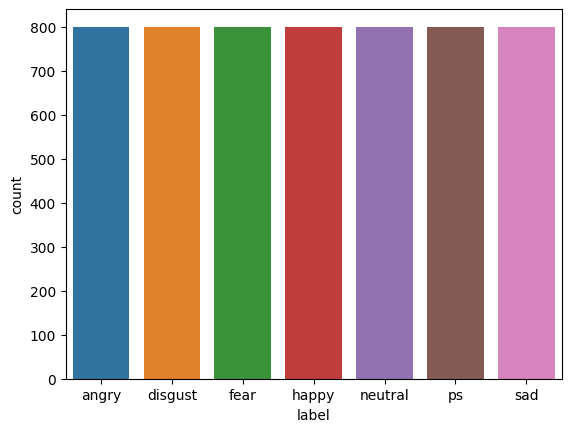

In [8]:
sns.countplot(data=df, x='label')
plt.show()

In [9]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

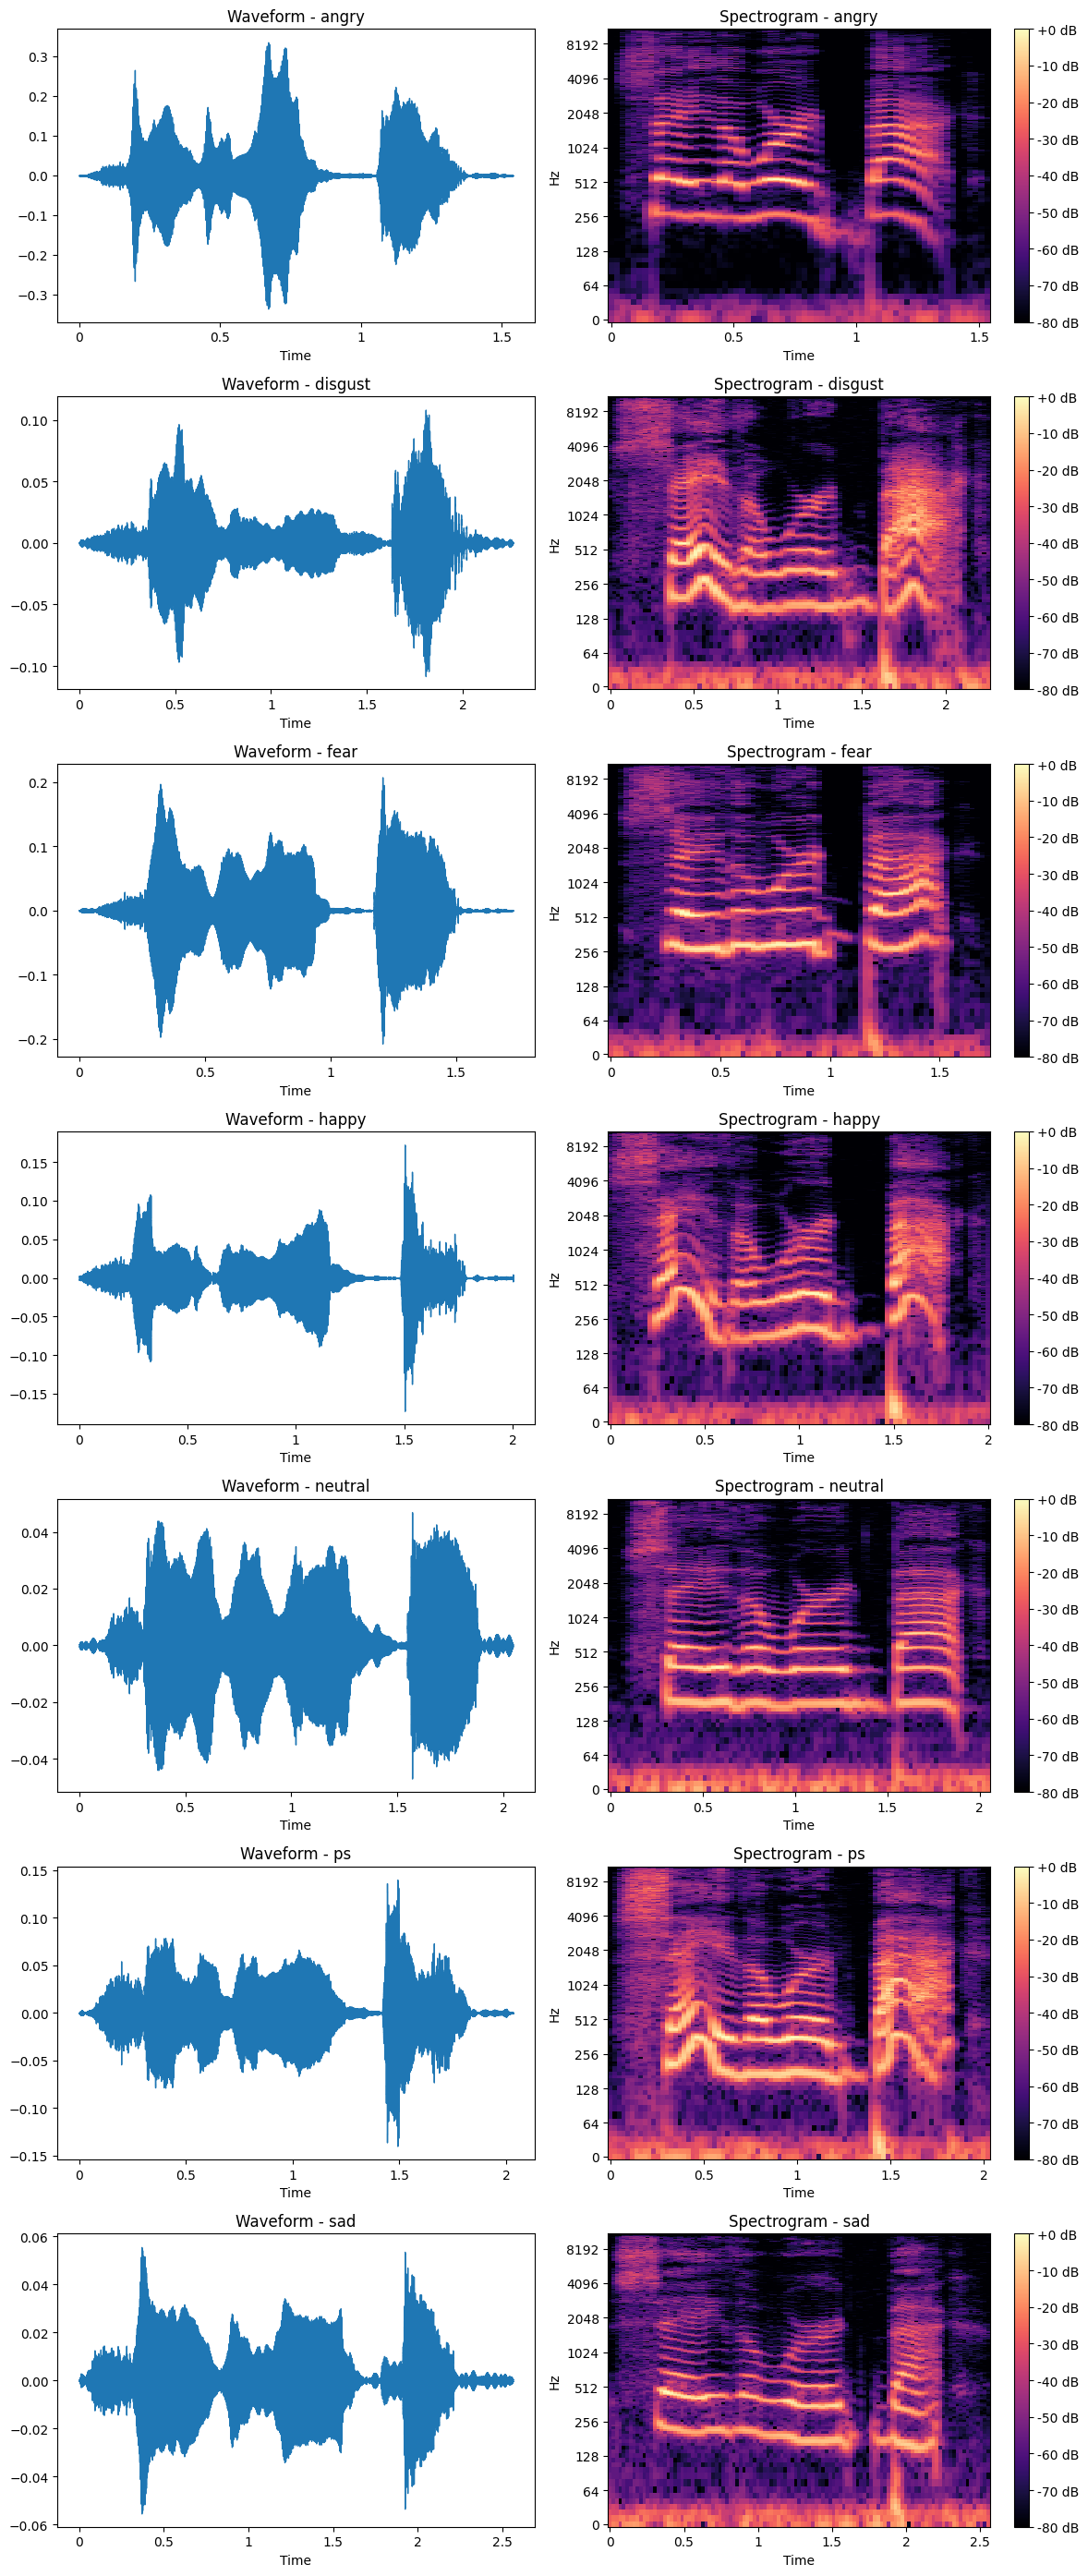

In [10]:
# Assuming df contains 'audio_file' and 'label' columns
emotions = df['label'].unique()  # Get all unique emotion labels

# Set up the figure size
plt.figure(figsize=(12, len(emotions) * 4))

for i, emotion in enumerate(emotions, 1):
    path = np.array(df['audio_file'][df['label'] == emotion])[0]  # Get the first file for each emotion
    data, sampling_rate = librosa.load(path)

    # Create subplot for waveform
    plt.subplot(len(emotions), 2, 2 * i - 1)
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.title(f"Waveform - {emotion}")

    # Create subplot for spectrogram
    plt.subplot(len(emotions), 2, 2 * i)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    librosa.display.specshow(D, sr=sampling_rate, x_axis="time", y_axis="log")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Spectrogram - {emotion}")

    # Play audio for reference
    display(Audio(path))

plt.tight_layout()
plt.show()

***

***

# Extract and save MFCC

***

***

In [11]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [12]:
# %%time
# X_mfcc = df['audio_file'].apply(lambda x: extract_mfcc(x))

In [13]:
# X_mfcc

In [14]:
import pickle

# Save as a pickle file
# with open("mfcc_features.pkl", "wb") as f:
#     pickle.dump(X_mfcc, f)


# Already Saved


with open("mfcc_features.pkl", "rb") as f:
    X_mfcc_saved = pickle.load(f)

In [15]:
X_mfcc = X_mfcc_saved

In [16]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(5600, 40)

In [17]:
## input split
X = np.expand_dims(X, -1)
X.shape

(5600, 40, 1)

In [18]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [19]:
y = y.toarray()

In [20]:
y.shape

(5600, 7)

***

***

# Create LSTM Model

***

***

In [21]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 4

In [23]:
# Train the model
%time history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64)

Epoch 1/50
70/70 [==============================] - 11s 59ms/step - loss: 0.8717 - accuracy: 0.6783 - val_loss: 0.2160 - val_accuracy: 0.9312
Epoch 2/50
70/70 [==============================] - 2s 31ms/step - loss: 0.2471 - accuracy: 0.9192 - val_loss: 0.1763 - val_accuracy: 0.9455
Epoch 3/50
70/70 [==============================] - 2s 30ms/step - loss: 0.1793 - accuracy: 0.9449 - val_loss: 0.0634 - val_accuracy: 0.9795
Epoch 4/50
70/70 [==============================] - 3s 37ms/step - loss: 0.1454 - accuracy: 0.9589 - val_loss: 0.0251 - val_accuracy: 0.9937
Epoch 5/50
70/70 [==============================] - 2s 30ms/step - loss: 0.0978 - accuracy: 0.9690 - val_loss: 0.0328 - val_accuracy: 0.9920
Epoch 6/50
70/70 [==============================] - 2s 34ms/step - loss: 0.0732 - accuracy: 0.9761 - val_loss: 0.0340 - val_accuracy: 0.9884
Epoch 7/50
70/70 [==============================] - 2s 29ms/step - loss: 0.0818 - accuracy: 0.9763 - val_loss: 0.0195 - val_accuracy: 0.9937
Epoch 8/50
7

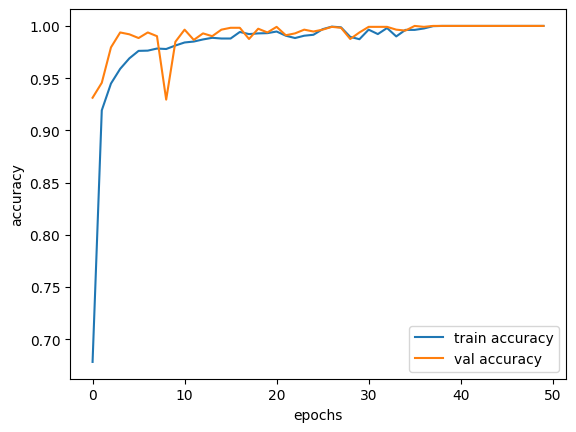

In [24]:
epochs = list(range(50))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

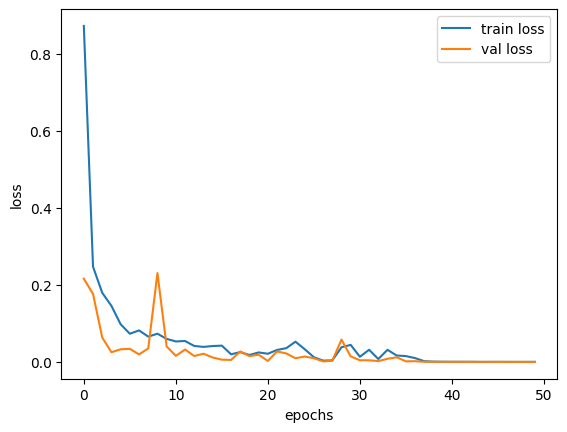

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()